## setup

In [172]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [173]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [174]:
import math

def lineplot_cluster(tables, column_names):
    tables_total = len(tables)
    columns_total = 2
    rows_total = math.ceil(tables_total / columns_total)   

    plt.figure(1, figsize=(18,rows_total*9))

    ix = 1
    for tablename in tables:
        days = df[df['tablename'] == tablename]['on_daytime']
        plt.subplot(rows_total, columns_total, ix)
        plt.title(tablename)
        plt.xticks(rotation=70)
        for column_name in column_names:
            total_rows_ts = df[df['tablename'] == tablename][column_name]
            plt.plot(days, total_rows_ts)
        plt.legend(loc="upper left")
        ix += 1

    plt.show()

## load data

In [175]:
project_title = 'ostro'
csv_file = "verify_prod-{project}-bq.csv".format(project=project_title)

In [176]:
df = pd.read_csv(csv_file,
                 header=None,
                 names=['tablename', 'on_day', 'days',
                        'total_rows', 'total_rows_table',
                        'total_rows_bq', 'total_rows_table_bq',
                        'absolute_diff', 'relative_diff', 'relative_diff_table'])

In [177]:
df[:4]

,tablename,on_day,days,total_rows,total_rows_table,total_rows_bq,total_rows_table_bq,absolute_diff,relative_diff,relative_diff_table
0,power_out,20180215,18,855668,15080517,855576,15088133,-92,-0.010752,-0.000610
1,power_out,20180216,18,887530,15080517,887530,15088133,0,0.000000,0.000000
2,power_out,20180217,18,631273,15080517,632027,15088133,754,0.119441,0.005000
3,power_out,20180218,18,683834,15080517,683802,15088133,-32,-0.004679,-0.000212


## basic statistics

In [178]:
count_nonzero(df.tablename.unique())

60

## distributions

In [179]:
df['on_daytime'] = pd.to_datetime(df['on_day'].astype(str), format='%Y%m%d')

### difference in absolute count

In [180]:
df['no_diff'] = df['absolute_diff'] == 0.0

In [181]:
df['no_diff'].value_counts()

False    697
True     375
Name: no_diff, dtype: int64

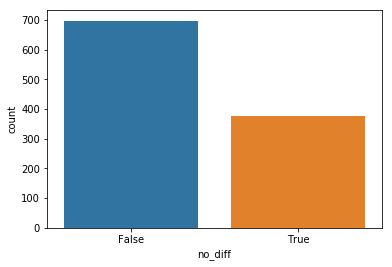

In [182]:
sns.countplot(df['no_diff'])

### relative difference

In [183]:
end_day = 20180301
threshold = 0.1
outliers = 10

In [184]:
df_timeslice = df[df['on_day'] < end_day]
mask = (abs(df_timeslice['relative_diff']) < threshold)
mask_outliers = (abs(df_timeslice['relative_diff']) < outliers)

In [185]:
mask.value_counts()

True     761
False     71
Name: relative_diff, dtype: int64

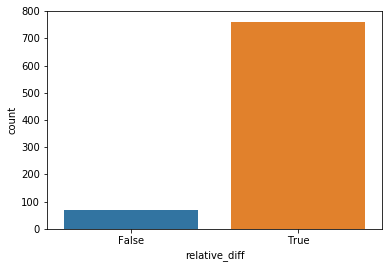

In [186]:
sns.countplot(mask)

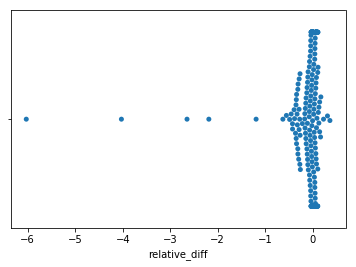

In [187]:
sns.swarmplot(df_timeslice[mask_outliers]['relative_diff'])

#### below threshold

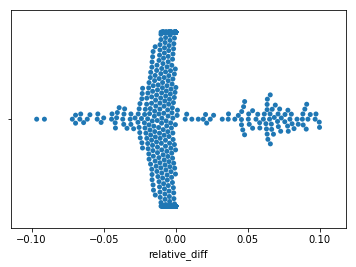

In [188]:
sns.swarmplot(df_timeslice[mask]['relative_diff'])

#### above threshold

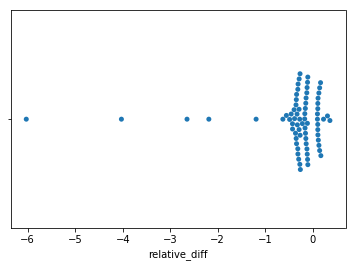

In [189]:
sns.swarmplot(df_timeslice[~mask]['relative_diff'])

#### per day

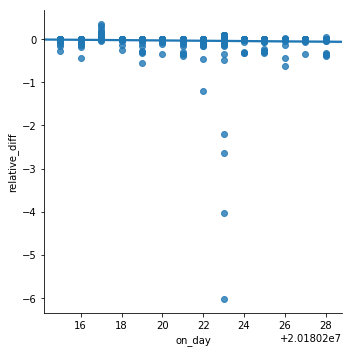

In [190]:
sns.lmplot('on_day', 'relative_diff', data=df_timeslice[mask_outliers])

#### per day and below threshold

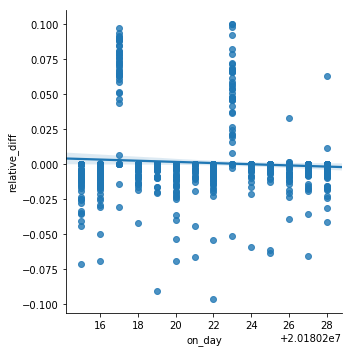

In [191]:
sns.lmplot('on_day', 'relative_diff', data=df_timeslice[mask])

### tables with a relative difference above threshold

In [192]:
tables_above_threshold = df_timeslice[~mask]['tablename'].unique()

In [ ]:
lineplot_cluster(tables_above_threshold, ['relative_diff'])

In [ ]:
lineplot_cluster(tables_above_threshold, ['total_rows', 'total_rows_bq'])

## make clusters = categories

* calculate lower and upper quartile value
* (tablename, lower quartile, upper quartile)
* run clustering
* clusters = (table,..), (table,..), ..
* plot tables from the same cluster together

In [195]:
from sklearn.cluster import KMeans

In [196]:
table_q = df.pivot(index='on_day', columns='tablename', values='total_rows').quantile([.2, .8])

In [197]:
table_q

tablename,power_out,storm_warn,maintenance_activity,wing_angle,rotation_speed
0.2,711455.2,418.8,13718.0,521487.8,431477.0
0.8,949683.8,745.8,46747.6,524519.8,1059950.6


In [198]:
preX = [([table_q[column].name]*2, table_q[column].values) for column in table_q]

In [199]:
preX[:3]

[(['power_out', 'power_out'], array([ 711455.2,  949683.8])),
 (['storm_warn', 'storm_warn'], array([ 418.8,  745.8])),
 (['maintenance_activity', 'maintenance_activity'], array([ 13718. ,  46747.6]))]

In [200]:
X = [q_values for _, q_values in preX]

In [201]:
X[:3]

[array([ 711455.2,  949683.8]),
 array([ 418.8,  745.8]),
 array([ 13718. ,  46747.6])]

In [202]:
kmeans = KMeans(n_clusters=7, random_state=0).fit(X)
kmeans.labels_

array([3, 0, 0, 0, 3, 0, 3, 0, 0, 1, 0, 2, 3, 0, 0, 0, 0, 0, 3, 3, 6, 3, 0,
       0, 0, 0, 0, 3, 6, 0, 3, 6, 0, 0, 0, 6, 3, 0, 3, 0, 0, 3, 0, 0, 0, 3,
       3, 0, 0, 0, 4, 4, 4, 5, 0, 0, 0, 3, 0, 0], dtype=int32)

In [203]:
clustered = [t + ([c,c],) for t,c in zip(preX, kmeans.labels_)]

In [204]:
clustered[:2]

[(['power_out', 'power_out'], array([ 711455.2,  949683.8]), [3, 3]),
 (['storm_warn', 'storm_warn'], array([ 418.8,  745.8]), [0, 0])]

In [205]:
clustered_col = [row for rows in [zip(t,v,c) for t,v,c in clustered] for row in rows]

In [206]:
clustered_col[:4]

[('power_out', 711455.19999999995, 3),
 ('power_out', 949683.80000000005, 3),
 ('storm_warn', 418.80000000000007, 0),
 ('storm_warn', 745.79999999999995, 0)]

In [207]:
df_clustered = pd.DataFrame(clustered_col, columns=['tablename', 'quartiles', 'cluster'])

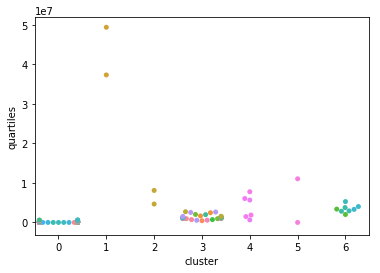

In [208]:
ax = sns.swarmplot(x='cluster', y='quartiles', hue='tablename', data=df_clustered)
# remove legend from axis 'ax'
ax.legend_.remove()
plt.show()

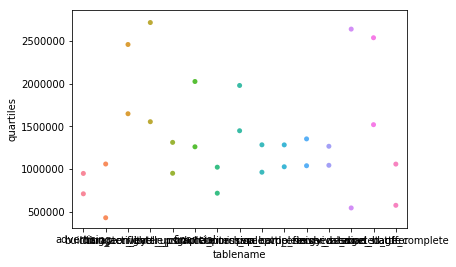

In [209]:
sns.swarmplot(x='tablename', y='quartiles', data=df_clustered[df_clustered['cluster'] == 3])

In [210]:
table_groups = df_clustered[['cluster', 'tablename']].groupby(['cluster'])
    
clusters = [df_clustered[df_clustered['cluster'] == g]['tablename'].unique()
               for g in table_groups.groups.keys()]

In [ ]:
lineplot_cluster(clusters[5], ['total_rows'])